### Description of the model

The time evolution of the activity of each node is governed by a first-order delay differential equation with time delay $D$.

$\frac{dR_k}{dt} = -R_k(t) + \phi\left[ I_{ext} + I_{stim}(k,t) + \sum J_{k,l}R_l(t-D)\right]$,

where $\phi = x$ if $x > 0$, and $0$ otherwise.

For a given node $k$ its angular position on the ring is $\theta_k = 2\pi k / N$, $k = 0, \dots, N-1$. Each node is connected to the other based on a distance-dependent coupling kernel $J_{kl}$:

$J_{kl} = J_0 / N + J_1 / N \cos(\Delta\theta_{kl})$, with $\Delta\theta_{kl} = 2\pi(k-l)/N$.

The external stimulus $I_{ext}$ was chosen in a way to set the stationary rate of a not to $R^{\infty} = 0.1$, which leads to:

$I_{ext, k} = R^{\infty}[1 - \sum J_{k,l}]$

Additionally, noise was added to each node. The noise $\eta(t)$ corresponded to 50% of the external current $I_{ext}$.

$\eta(t) = I_{ext}\mathcal{U}(-0.5, 0.5) $,

where $\mathcal{U}$ indicates that the noise in drawn from a uniforma distribution bounded between [-0.5, 0.5] (hence 50% of the external drive). The value of $\eta(t)$ is zeroed if it assume negative values at any moment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numba import *
from tqdm import tqdm

#### Import core model functions

In [2]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/nicole_model")

In [3]:
from src.integration import config_simulation
from src.model import create_ring, dRdt
from src.utils import batch

In [4]:
def simulate_one_ring(
    state="SU",
    integration="euler",
    N=100,
    trials=1,
    h=0.01,
    tsim=10.0,
    trans=5.5,
    delay=10,
    decim=10,
    s_pos=[0],
    s_on=[0],
    s_off=[0],
    A_stim=[0],
    sig_stim=1,
    batch_size=1,
    verbose=False,
):
    """
    Simulates a neural network with one ring of neurons.

    Parameters
    ----------
    state : str, optional
        The type of network to simulate, either "SU" for synchronous
        irregular (default), or "SB" for synchronous bursty.
    integration : str, optional
        The numerical integration method to use, either "euler" (default) or
        "rk4".
    N : int, optional
        The number of neurons in the network (default 100).
    trials : int, optional
        The number of times to simulate the network with different
        external inputs (default 1).
    h : float, optional
        The time step of the simulation, in seconds (default 0.01).
    tsim : float, optional
        The total duration of the simulation, in seconds (default 10.0).
    trans : float, optional
        The duration of the transient period to discard from the output, in seconds (default 5.5).
    delay : int, optional
        The delay (in number of time steps) in the connectivity kernel
        (default 10).
    decim : int or None, optional
        The decimation factor to apply to the output, i.e. the number of time steps between each
        saved time point. If None, no decimation is applied (default 10).
    s_pos : list of int, optional
        The positions in number of nodes of each external stimulus (default [0]).
    s_on : list of float, optional
        The times in seconds at which each external stimulus starts (default [0]).
    s_off : list of float, optional
        The times in seconds at which each external stimulus stops (default [0]).
    A_stim : list of float, optional
        The amplitude of each external stimulus (default [0]).
    sig_stim : float, optional
        The standard deviation of the Gaussian profile of each external stimulus (default 1).
    batch_size : int, optional
        The number of trials to simulate simultaneously. Increase this to
        reduce memory usage (default 1).
    verbose : bool, optional
        Whether to display a progress bar (default False).

    Returns
    -------
    R : xarray.DataArray
        A DataArray containing the firing rates of the neurons in the network.
        The dimensions are "trials", "times", and "nodes", and the coordinates
        are the trial index, the time of the simulation, and the angular position
    of the neurons, respectively.
    """
    fint, steps, times = config_simulation(integration, tsim, h)

    s_on = [int(onset / h) for onset in s_on]
    s_off = [int(offset / h) for offset in s_off]

    # Create first ring
    J, Iext, Istim, theta, R = create_ring(
        state=state,
        N=N,
        trials=trials,
        steps=steps,
        s_pos=s_pos,
        s_on=s_on,
        s_off=s_off,
        A_stim=A_stim,
        sig_stim=sig_stim,
    )

    trials_idx = np.arange(0, trials, dtype=int)

    # Allocate firing rate matrix
    R = np.empty((trials, steps, N))

    def _simulate_batch(i_):
        R[i_, : delay + 1] = np.random.uniform(0, 0.1, size=R[i_, : delay + 1].shape)
        # Solve the ODE using RK4
        for t in range(delay, steps):
            R[i_, t, :] = fint(
                dRdt,
                R[i_, t - 1, :],
                times[t],
                h,
                Iext[i_, t],
                Istim[t],
                R[i_, t - delay, :] @ J,
            )

    # Simulate trial batches
    nbatches = int(trials / batch_size)
    pbar = batch(trials_idx, n=batch_size)

    if verbose:
        pbar = tqdm(pbar)

    n = 1
    for indexes in pbar:
        _simulate_batch(indexes)
        if verbose:
            pbar.set_description(f"Simulation trials batch {n}/{nbatches}")
            n = n + 1

    # Apply decimation
    if isinstance(decim, int):
        times = times[::decim]
        R = R[:, ::decim, :]

    trans = int(trans / (decim * h))
    # Discard transient
    R = R[:, trans:, :]

    R = xr.DataArray(
        R, dims=("trials", "times", "nodes"), coords=(trials_idx, times[:-trans], theta)
    )

    # Discard transient
    R = R.sel(times=slice(trans))

    return R

##### Simulating SU trials

In [5]:
RSU = simulate_one_ring(
    state="SU",
    integration="rk4",
    tsim=45 + 40,
    trans=40,
    trials=50,
    batch_size=25,
    verbose=True,
    decim=10,
)

Simulation trials batch 2/2: : 2it [00:01,  1.47it/s]


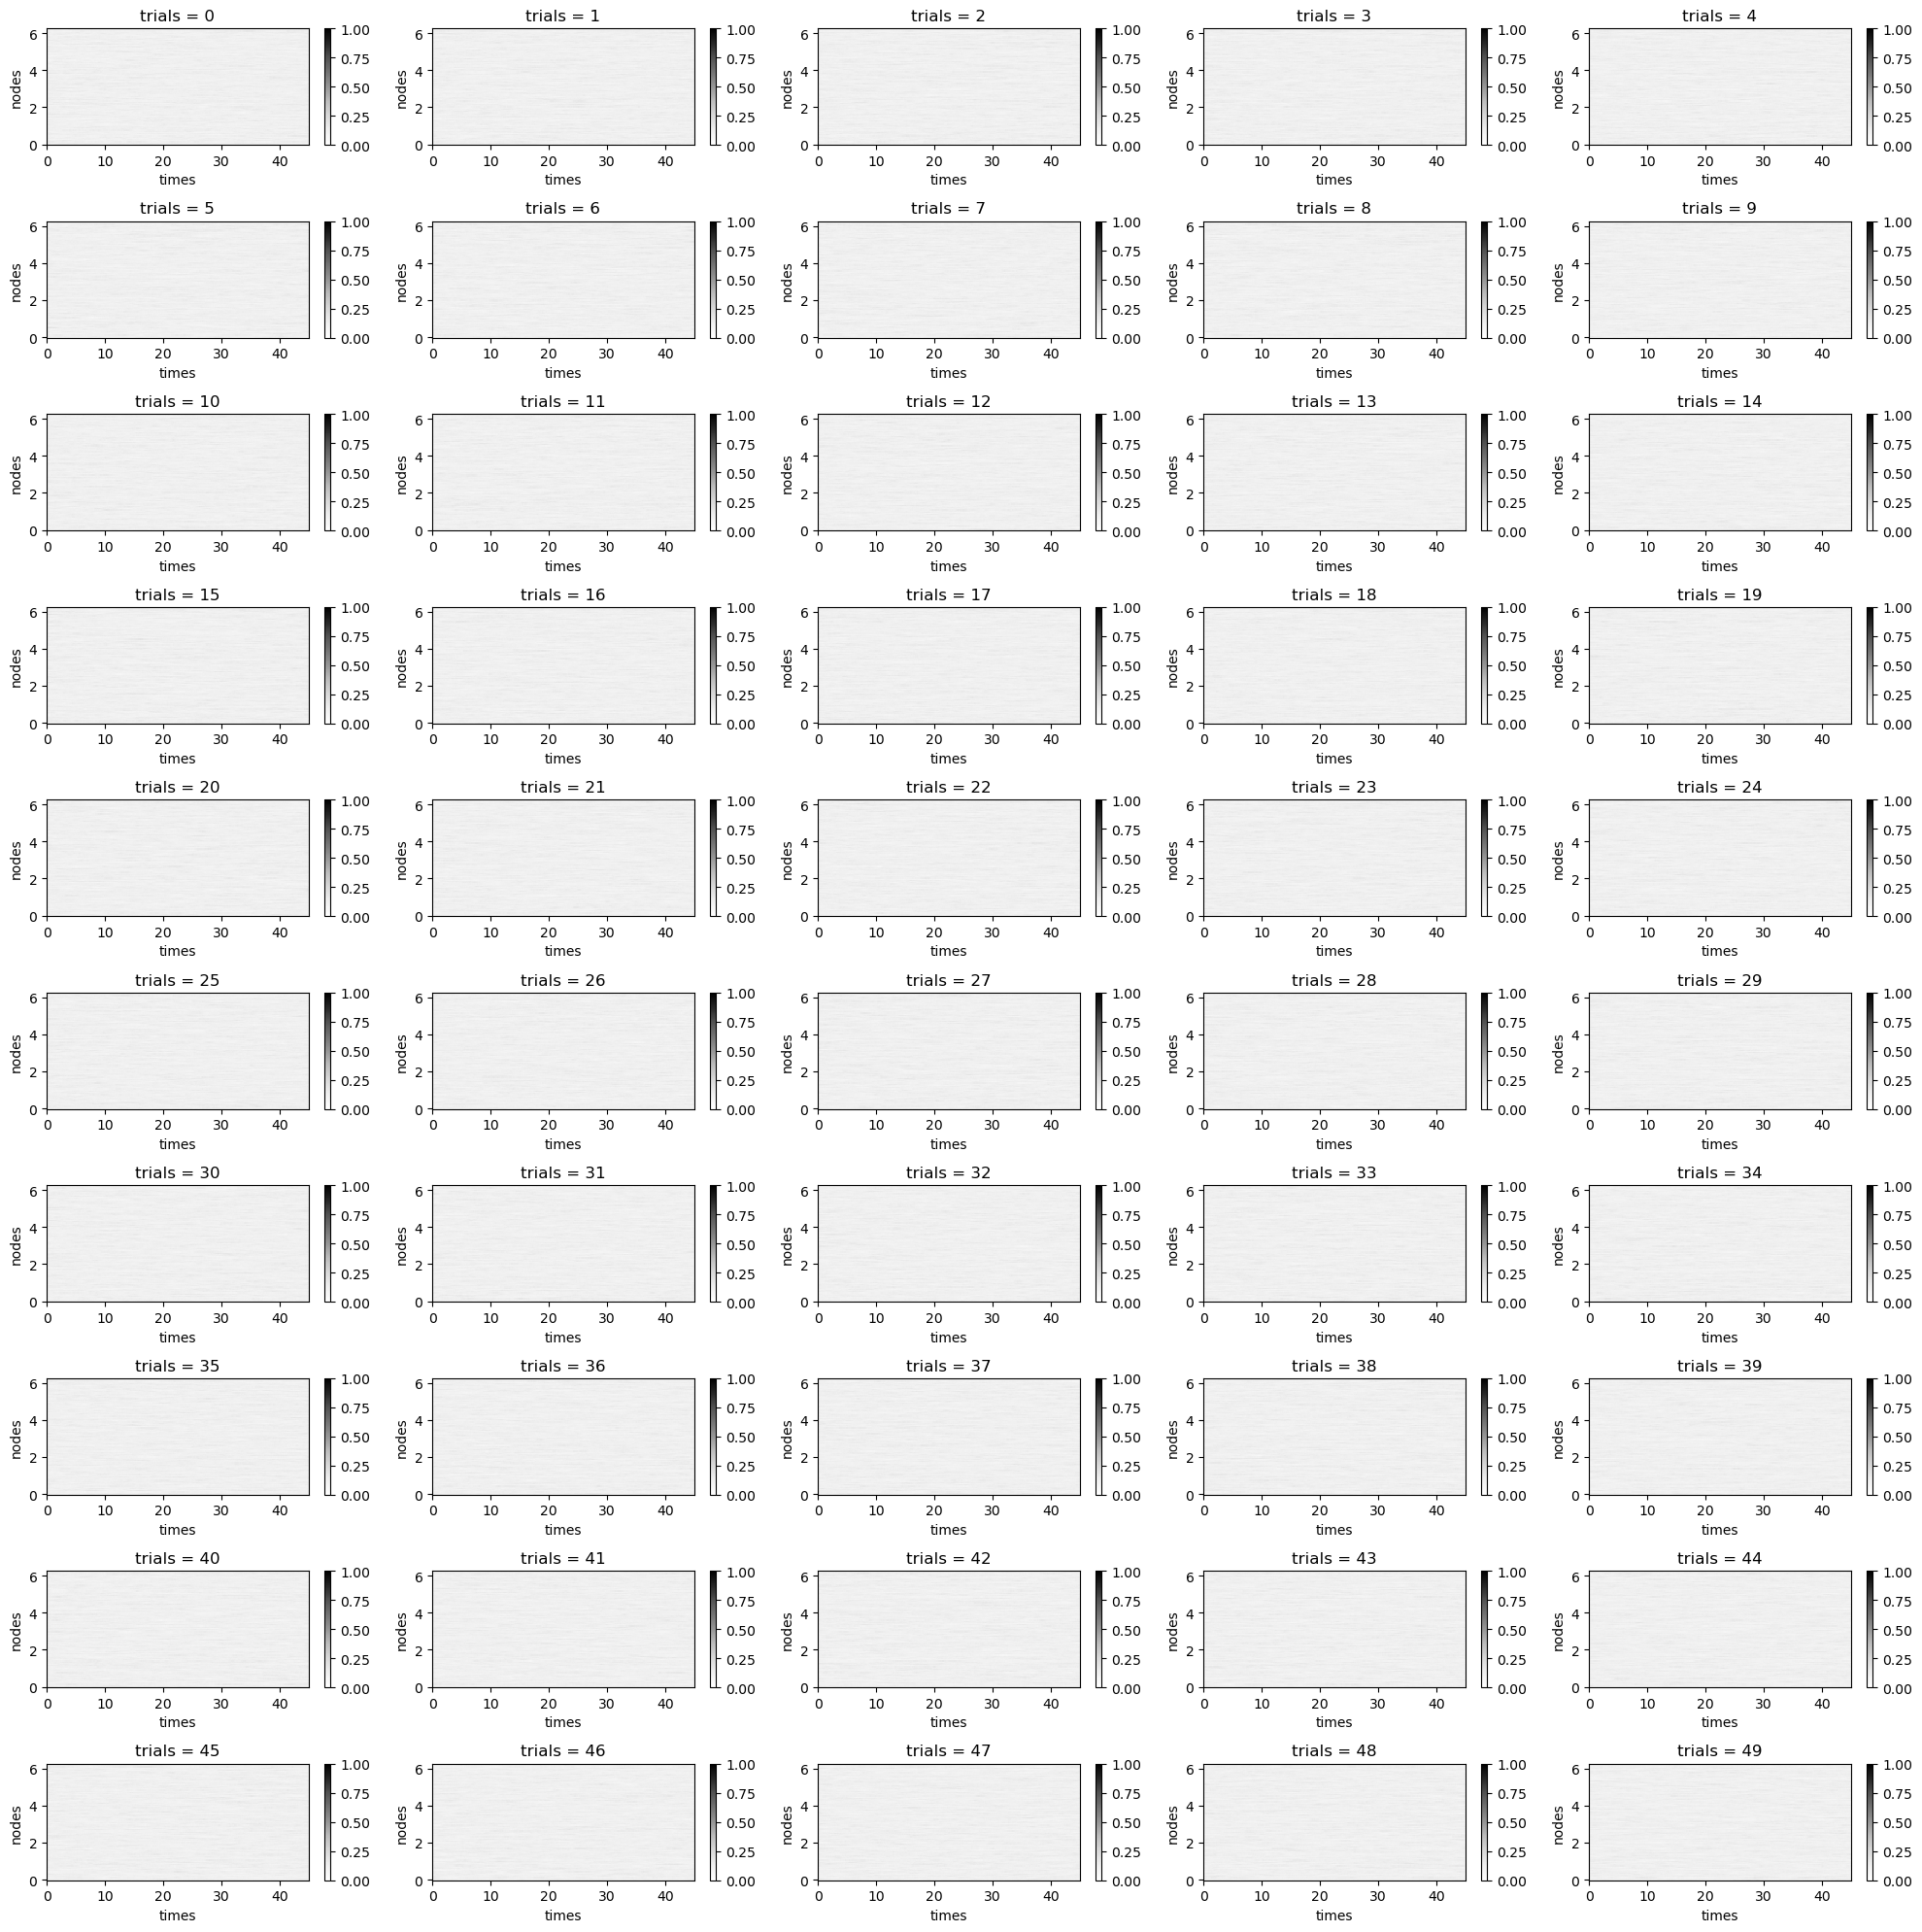

In [6]:
plt.figure(figsize=(20, 20))
for i in range(50):
    plt.subplot(10, 5, i + 1)
    RSU[i].T.plot.imshow(cmap="Greys", origin="lower", vmin=0, vmax=1)
plt.tight_layout()

##### Simulating SB trials

In [7]:
RSB = simulate_one_ring(
    state="SB",
    integration="rk4",
    tsim=45 + 40,
    trans=40,
    trials=100,
    batch_size=100,
    verbose=True,
    decim=10,
)

Simulation trials batch 1/1: : 1it [00:01,  1.84s/it]


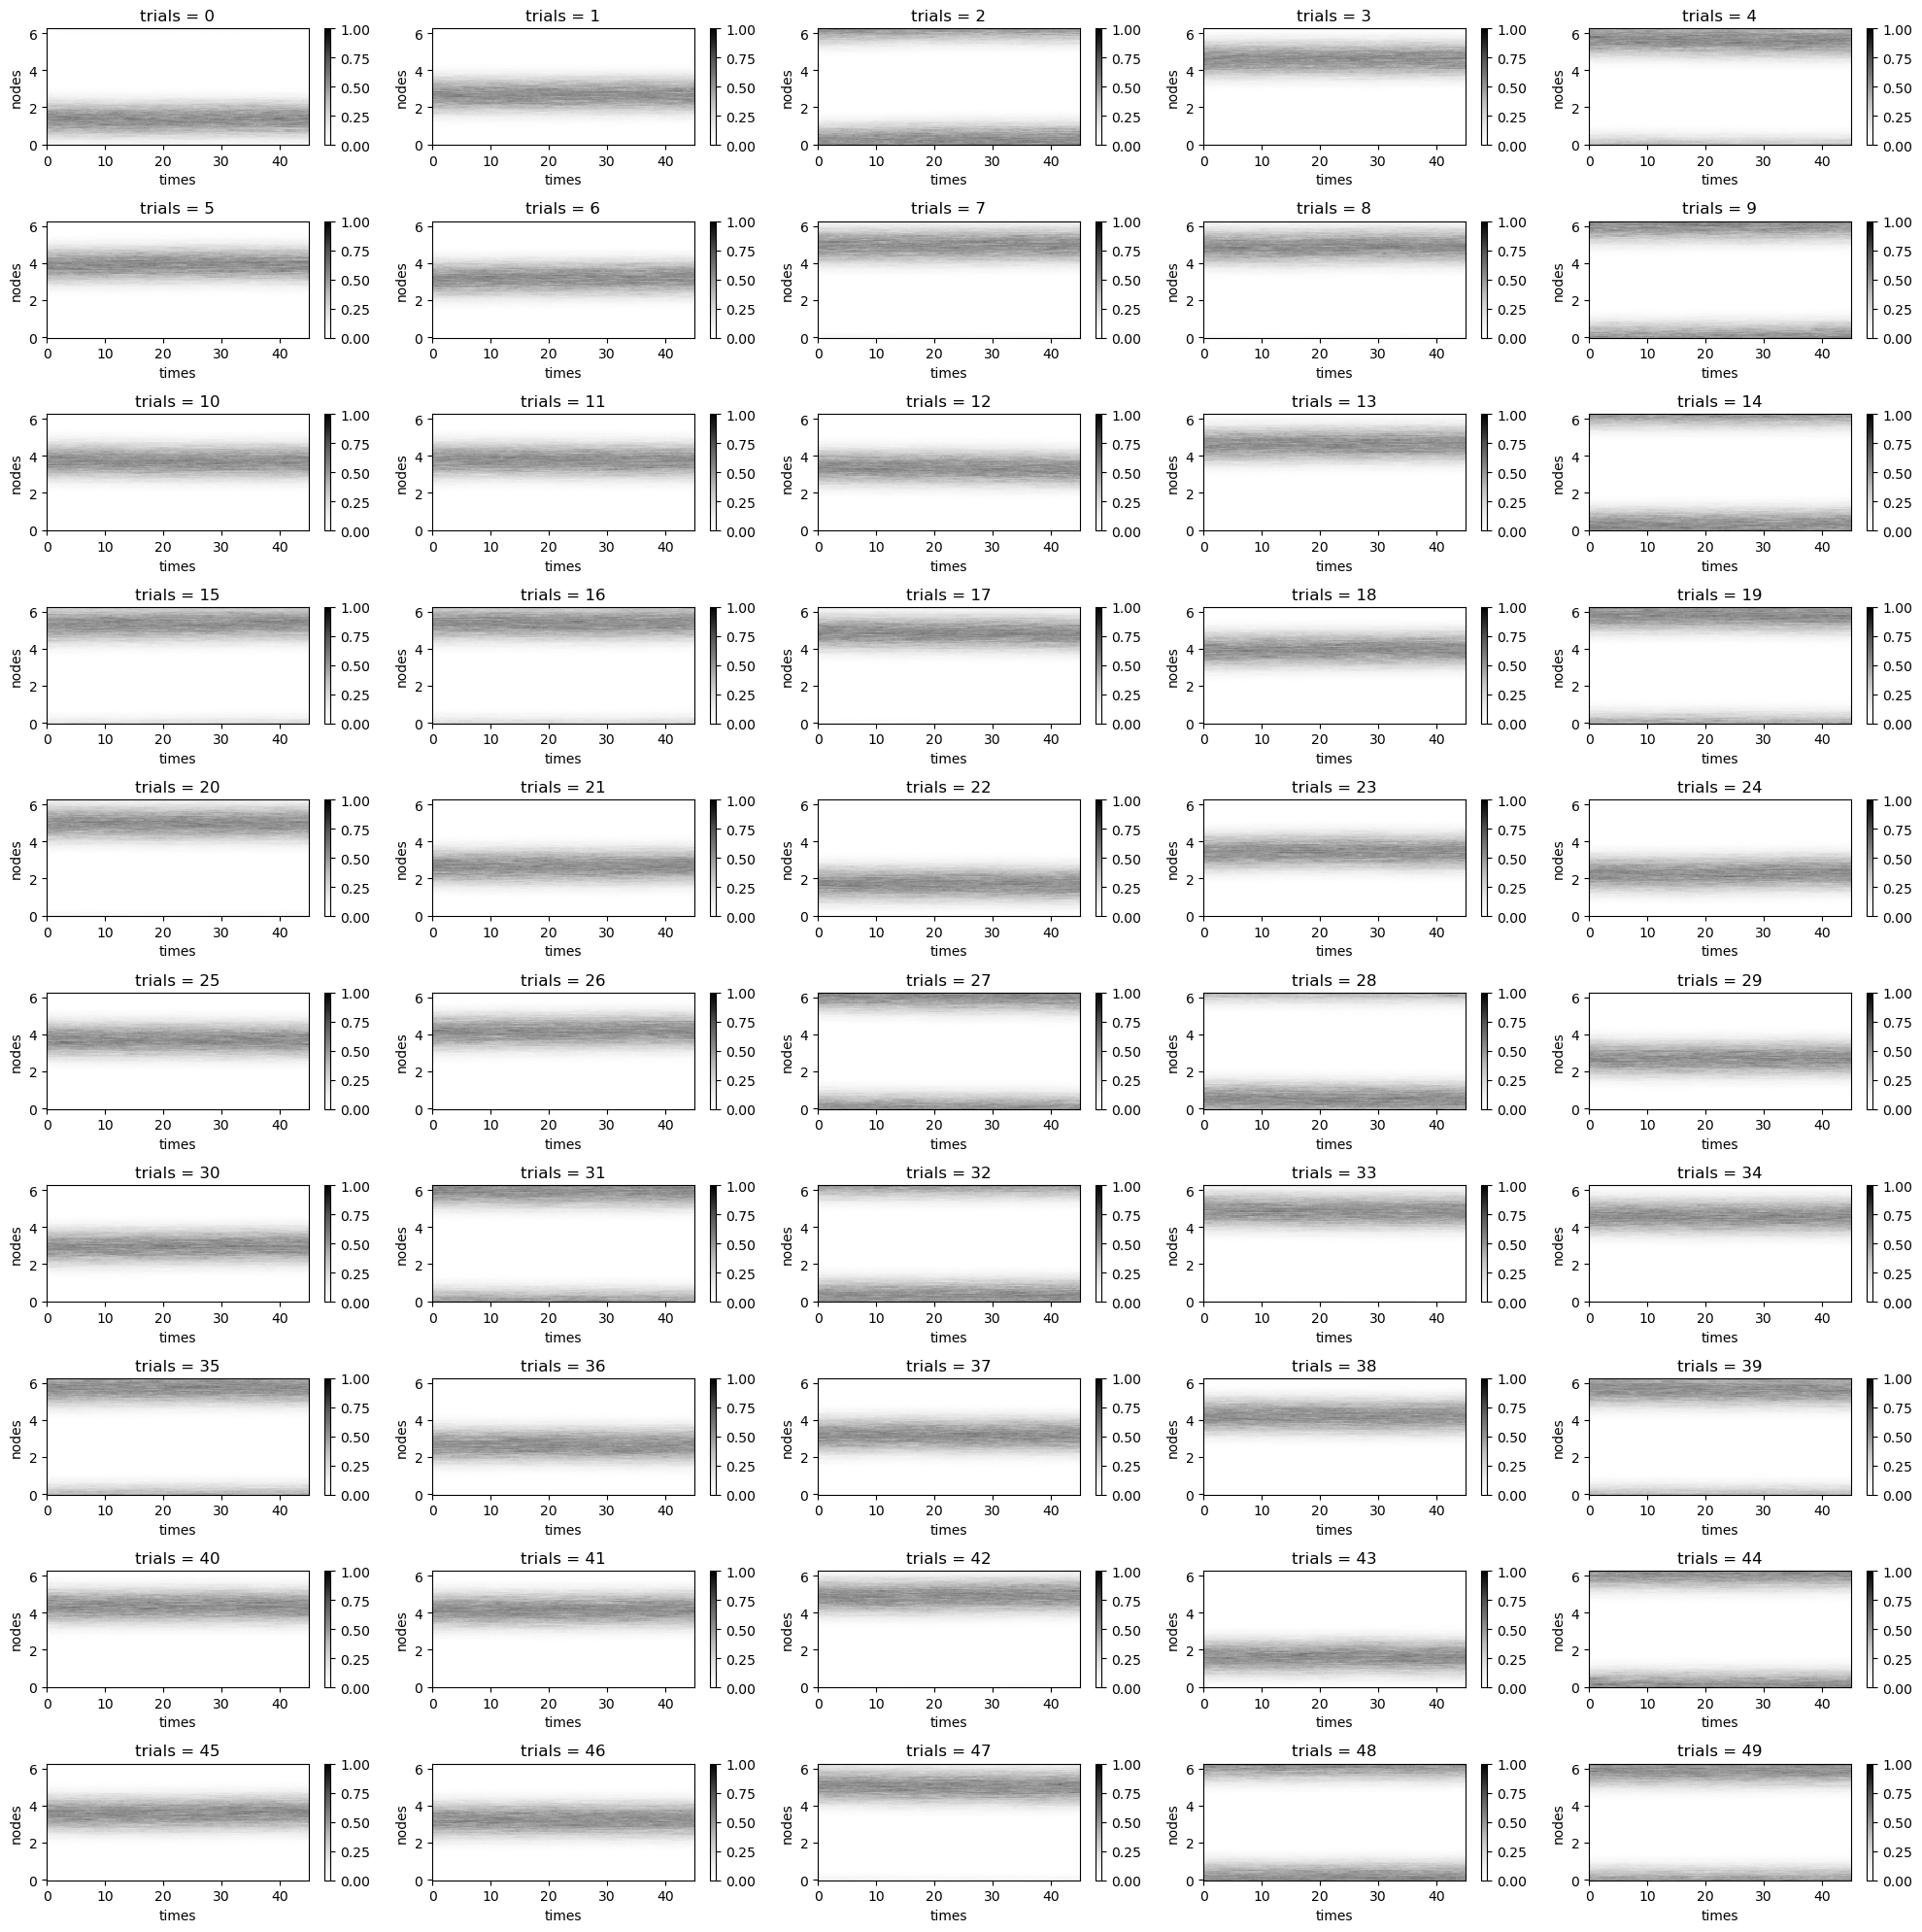

In [8]:
plt.figure(figsize=(20, 20))
for i in range(50):
    plt.subplot(10, 5, i + 1)
    RSB[i].T.plot.imshow(cmap="Greys", origin="lower", vmin=0, vmax=1)
plt.tight_layout()

##### Adding stimulus

In [9]:
RSU = simulate_one_ring(
    state="SU",
    integration="rk4",
    tsim=45 + 40,
    trans=40,
    trials=50,
    batch_size=25,
    verbose=True,
    decim=10,
    s_pos=[80],
    s_on=[10 + 40],
    s_off=[25 + 40],
    A_stim=2.0,
    sig_stim=8,
)

RSB = simulate_one_ring(
    state="SB",
    integration="rk4",
    tsim=45 + 40,
    trans=40,
    trials=50,
    batch_size=25,
    verbose=True,
    decim=10,
    s_pos=[80],
    s_on=[10 + 40],
    s_off=[25 + 40],
    A_stim=2.0,
    sig_stim=8,
)

Simulation trials batch 2/2: : 2it [00:01,  1.69it/s]
Simulation trials batch 2/2: : 2it [00:01,  1.69it/s]


Text(0, 0.5, 'node id.')

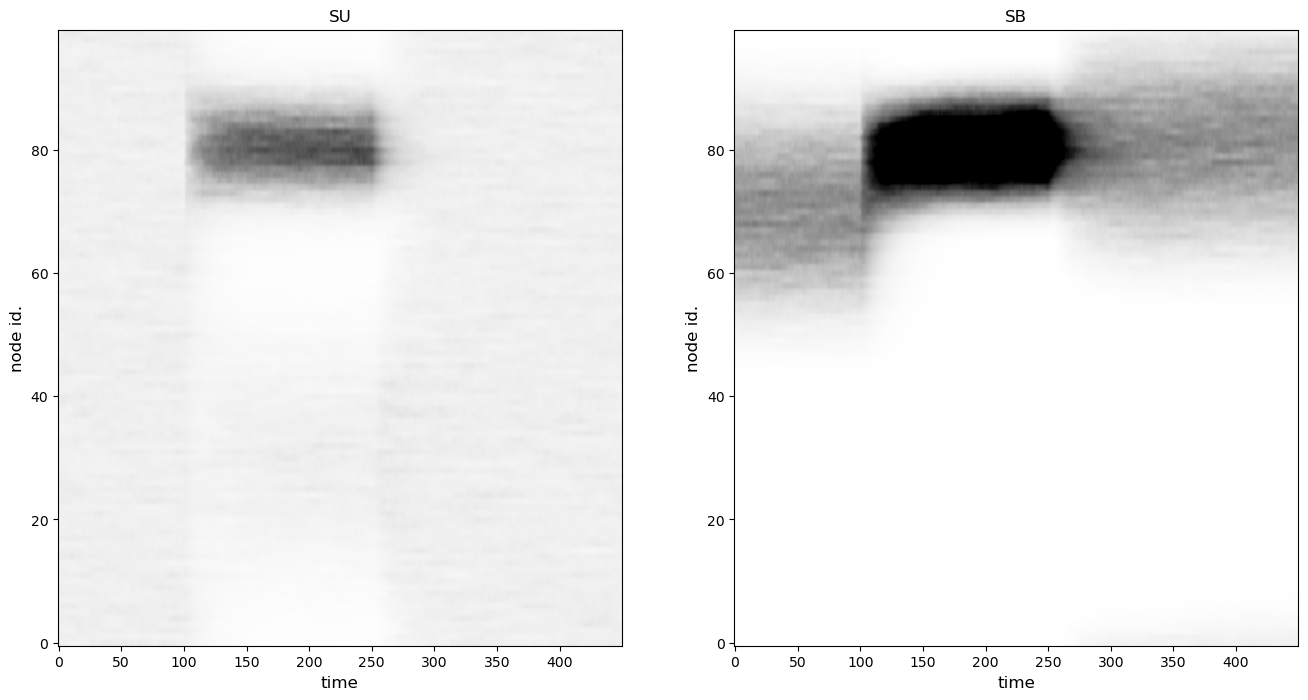

In [10]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(RSU[20].T, cmap="Greys", origin="lower", vmin=0, vmax=1, aspect="auto")
plt.title("SU", fontsize=12)
plt.xlabel("time", fontsize=12)
plt.ylabel("node id.", fontsize=12)
plt.subplot(1, 2, 2)
plt.imshow(RSB[20].T, cmap="Greys", origin="lower", vmin=0, vmax=1, aspect="auto")
plt.title("SB", fontsize=12)
plt.xlabel("time", fontsize=12)
plt.ylabel("node id.", fontsize=12)

#### IPP analysis

In [11]:
# Stimulus positions
Spos = np.array([0, 25, 50, 75])

In [12]:
RSU = []

for spos in Spos:
    RSU += [
        simulate_one_ring(
            state="SU",
            integration="rk4",
            tsim=45 + 40,
            trans=40,
            trials=1000,
            batch_size=200,
            verbose=True,
            decim=10,
            s_pos=[spos],
            s_on=[10 + 40],
            s_off=[25 + 40],
            A_stim=2.0,
            sig_stim=8,
        )
    ]

RSU = xr.concat(RSU, "trials").assign_coords({"trials": range(4000)})

Simulation trials batch 5/5: : 5it [00:44,  8.86s/it]
Simulation trials batch 5/5: : 5it [00:45,  9.13s/it]
Simulation trials batch 5/5: : 5it [00:45,  9.11s/it]
Simulation trials batch 5/5: : 5it [00:46,  9.25s/it]


In [13]:
RSB = []

for spos in Spos:
    RSB += [
        simulate_one_ring(
            state="SB",
            integration="rk4",
            tsim=45 + 40,
            trans=40,
            trials=1000,
            batch_size=200,
            verbose=True,
            decim=10,
            s_pos=[spos],
            s_on=[10 + 40],
            s_off=[25 + 40],
            A_stim=2.0,
            sig_stim=8,
        )
    ]

RSB = xr.concat(RSB, "trials").assign_coords({"trials": range(4000)})

Simulation trials batch 5/5: : 5it [00:45,  9.03s/it]
Simulation trials batch 5/5: : 5it [00:45,  9.16s/it]
Simulation trials batch 5/5: : 5it [00:45,  9.14s/it]
Simulation trials batch 5/5: : 5it [00:45,  9.11s/it]


#### PID analysis

In [14]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/nicole_model")

In [15]:
from src.infodyn.conn_pid import conn_pid

In [16]:
y = np.repeat(Spos, 1000)

In [17]:
mi_node, unique, infotot, redundancy, synergy = conn_pid(
    RSU.transpose("trials", "nodes", "times"),
    y,
    roi="nodes",
    times="times",
    mi_type="cd",
    dt=1,
    verbose=True,
)

Defining links (n_roi=100; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute PID on 4950 connectivity pairs
    Apply the Gaussian Copula Rank Normalization
    Estimating PID in the network
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████| Estimating unique information and synergy : 5150/5150 [07:00<00:00,   12.26it/s]


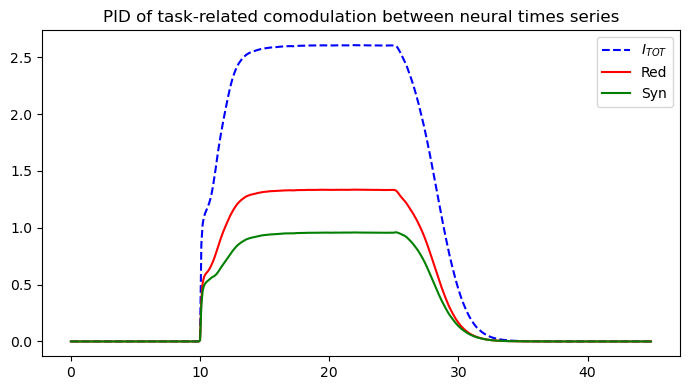

In [18]:
# Plotting
plt.figure(figsize=(7, 4))

times = RSU.times.data

plt.plot(
    times,
    infotot.mean("roi").squeeze(),
    color="blue",
    linestyle="--",
    label=r"$I_{TOT}$",
)
plt.plot(times, redundancy.mean("roi").squeeze(), color="red", label="Red")
plt.plot(times, synergy.mean("roi").squeeze(), color="green", label="Syn")
plt.legend()

plt.title("PID of task-related comodulation between neural times series")

plt.tight_layout()
plt.show()

In [19]:
mi_node_, unique_, infotot_, redundancy_, synergy_ = conn_pid(
    RSB.transpose("trials", "nodes", "times"),
    y,
    roi="nodes",
    times="times",
    mi_type="cd",
    dt=1,
    verbose=True,
)

Defining links (n_roi=100; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute PID on 4950 connectivity pairs
    Apply the Gaussian Copula Rank Normalization
    Estimating PID in the network
100%|████████████████████████████████████████████████████| Estimating unique information and synergy : 5150/5150 [06:58<00:00,   12.31it/s]


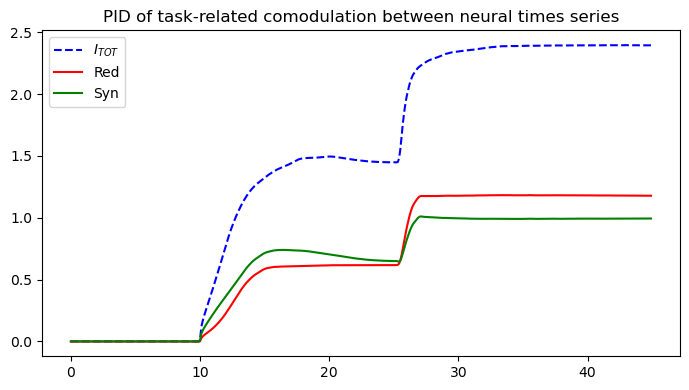

In [20]:
# Plotting
plt.figure(figsize=(7, 4))

times = RSB.times.data

plt.plot(
    times,
    infotot_.mean("roi").squeeze(),
    color="blue",
    linestyle="--",
    label=r"$I_{TOT}$",
)
plt.plot(times, redundancy_.mean("roi").squeeze(), color="red", label="Red")
plt.plot(times, synergy_.mean("roi").squeeze(), color="green", label="Syn")
plt.legend()

plt.title("PID of task-related comodulation between neural times series")

plt.tight_layout()
plt.show()

Text(0.5, 0, 'time')

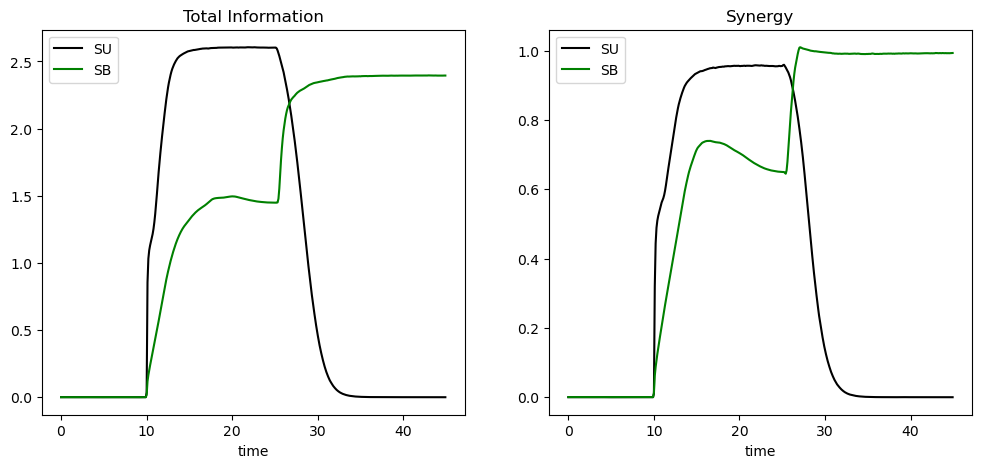

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(times, infotot.mean("roi").squeeze(), color="black", label=r"$I_{TOT}$")
plt.plot(times, infotot_.mean("roi").squeeze(), color="green", label=r"$I_{TOT}$")
plt.legend(["SU", "SB"])
plt.title("Total Information")
plt.xlabel("time")
plt.subplot(122)
plt.plot(times, synergy.mean("roi").squeeze(), color="black", label=r"$I_{TOT}$")
plt.plot(times, synergy_.mean("roi").squeeze(), color="green", label=r"$I_{TOT}$")
plt.legend(["SU", "SB"])
plt.title("Synergy")
plt.xlabel("time")